In [1]:
import copy

In [2]:
import itertools

In [3]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
import pandas as pd

In [7]:
from prophet import Prophet

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [8]:
from sklearn.metrics import mean_squared_error

In [9]:
from bayes_opt import BayesianOptimization

# Data Reading

In [10]:
data = pd.read_csv('google-data.csv')

In [11]:
df = copy.deepcopy(data)

In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


# Data Preprocessing

In [14]:
df['Date'] = pd.to_datetime(df['Date'])

# Data Analysis

In [15]:
df.iloc[:,1:].describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1259.0,6.527041e+02,1.756306e+02,350.053253,5.282871e+02,6.000026e+02,7.740150e+02,1.075200e+03
High,1259.0,6.574757e+02,1.766274e+02,350.391052,5.326152e+02,6.032365e+02,7.791200e+02,1.078490e+03
Low,1259.0,6.474337e+02,1.747328e+02,345.512787,5.242325e+02,5.944537e+02,7.686625e+02,1.063550e+03
Close,1259.0,6.526570e+02,1.758210e+02,349.164032,5.284294e+02,5.980056e+02,7.727200e+02,1.077140e+03
Adj Close,1259.0,6.526570e+02,1.758210e+02,349.164032,5.284294e+02,5.980056e+02,7.727200e+02,1.077140e+03
Volume,1259.0,2.414928e+06,1.672160e+06,7900.000000,1.336900e+06,1.842300e+06,3.090850e+06,2.328310e+07


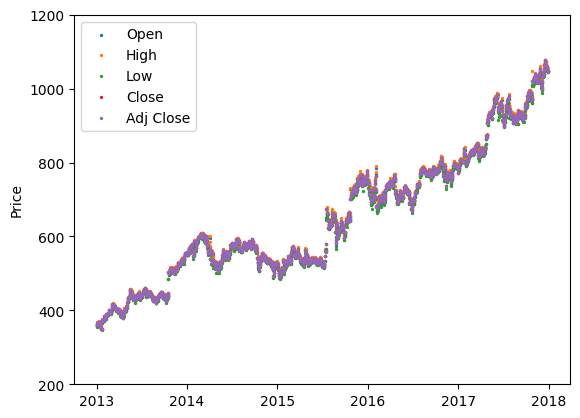

In [16]:
plt.scatter(df['Date'],df['Open'],s=2,label='Open');
plt.scatter(df['Date'],df['High'],s=2,label='High');
plt.scatter(df['Date'],df['Low'],s=2,label='Low');
plt.scatter(df['Date'],df['Close'],s=2,label='Close');
plt.scatter(df['Date'],df['Adj Close'],s=2,label='Adj Close');

plt.ylim([200,1200]);

plt.legend();

plt.ylabel('Price');

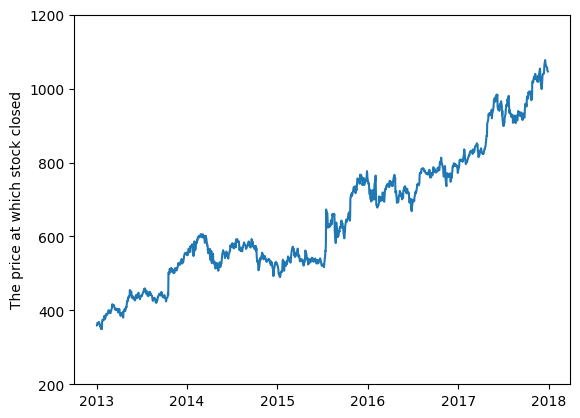

In [17]:
plt.plot(df['Date'],df['Close']);
plt.ylabel('The price at which stock closed')
plt.ylim([200,1200]);

# Facebook Prophet Model

In [18]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [19]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2017-12-22,1061.109985,1064.199951,1059.439941,1060.119995,1060.119995,755100
1255,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
1256,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
1257,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100
1258,2017-12-29,1046.719971,1049.699951,1044.900024,1046.400024,1046.400024,887500


In [20]:
closePrice = df[['Date','Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [21]:
closePrice.head()

,ds,y
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


In [22]:
model = Prophet(interval_width=0.95)

In [23]:
model.fit(closePrice);

21:43:02 - cmdstanpy - INFO - Chain [1] start processing
21:43:03 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
print(f"{model.changepoint_prior_scale = },{model.seasonality_prior_scale = }")

model.changepoint_prior_scale = 0.05,model.seasonality_prior_scale = 10.0


In [25]:
timeframe = model.make_future_dataframe(periods=100, freq='D')

In [26]:
forecast = model.predict(timeframe)

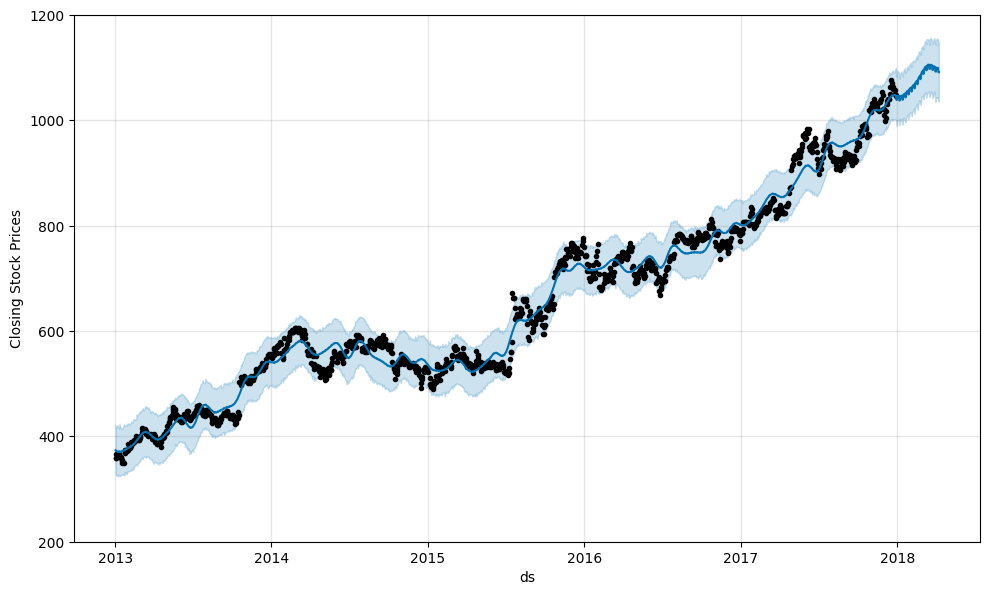

In [27]:
model.plot(forecast,ylabel='Closing Stock Prices');
plt.ylim([200,1200]);

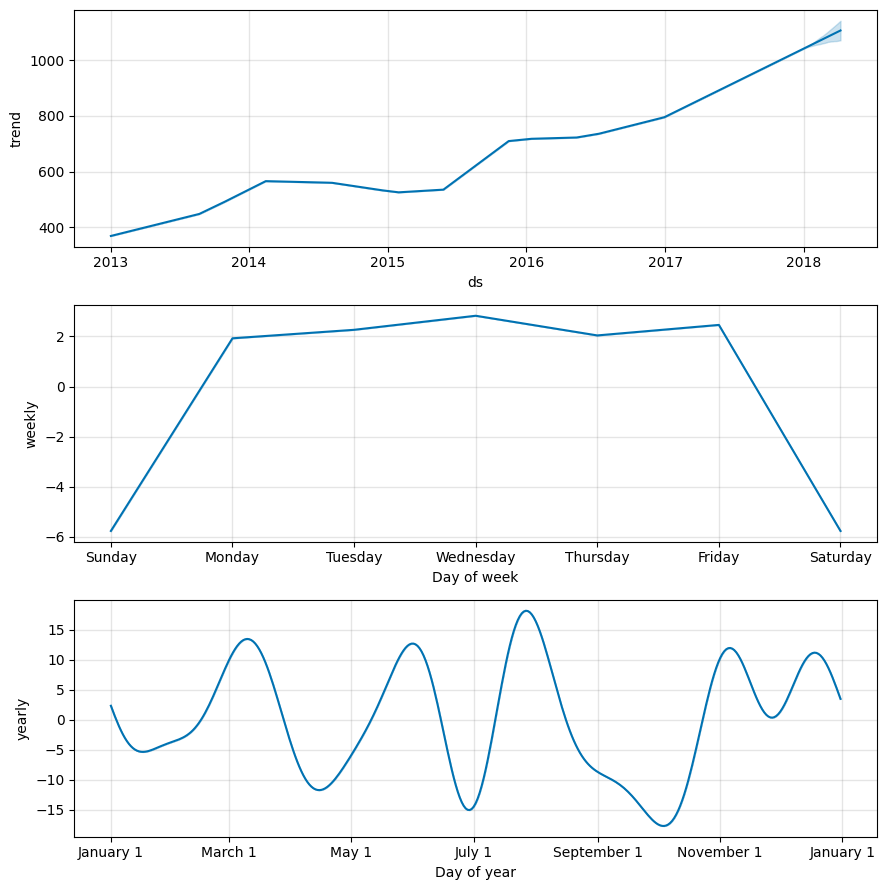

In [28]:
model.plot_components(forecast);

# Hyperparameter Tuning

In [29]:
parameters = {
    'changepoint_prior_scale': [0.001,0.01,0.1,0.5],
    'seasonality_prior_scale': [0.01,0.1,1.0,10]
}

## Full Factorial Optimization

In [30]:
combinations = [dict(zip(parameters.keys(),v)) for v in itertools.product(*parameters.values())]

In [31]:
RMSE = [] # root mean square errors

for params in combinations:
    
    model = Prophet(interval_width=0.95,**params)
    model = model.fit(closePrice)

    forecast = model.predict()

    rmse = np.sqrt(mean_squared_error(closePrice.y.values,forecast.yhat.values))

    RMSE.append(rmse)

21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:36 - cmdstanpy - INFO - Chain [1] start processing
21:43:36 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:40 - cmdstanpy - INFO - Chain [1] done processing
21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:44 - cmdstanpy - INFO - Chain [1]

In [32]:
tuning_results = pd.DataFrame(combinations)
tuning_results['RMSE'] = RMSE
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale       RMSE
0                     0.001                     0.01  52.054285
1                     0.001                     0.10  51.918406
2                     0.001                     1.00  52.088367
3                     0.001                    10.00  52.103083
4                     0.010                     0.01  28.342933
5                     0.010                     0.10  28.002443
6                     0.010                     1.00  27.910856
7                     0.010                    10.00  28.234993
8                     0.100                     0.01  19.305226
9                     0.100                     0.10  19.159935
10                    0.100                     1.00  19.380933
11                    0.100                    10.00  19.329895
12                    0.500                     0.01  17.548837
13                    0.500                     0.10  17.553278
14                    0.500             

In [33]:
best_params = combinations[np.argmin(RMSE)]

In [34]:
best_params

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10}

## Full Factorial Result

In [35]:
model = Prophet(interval_width=0.95,**best_params)

In [36]:
model.fit(closePrice);

21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
forecast = model.predict(timeframe)

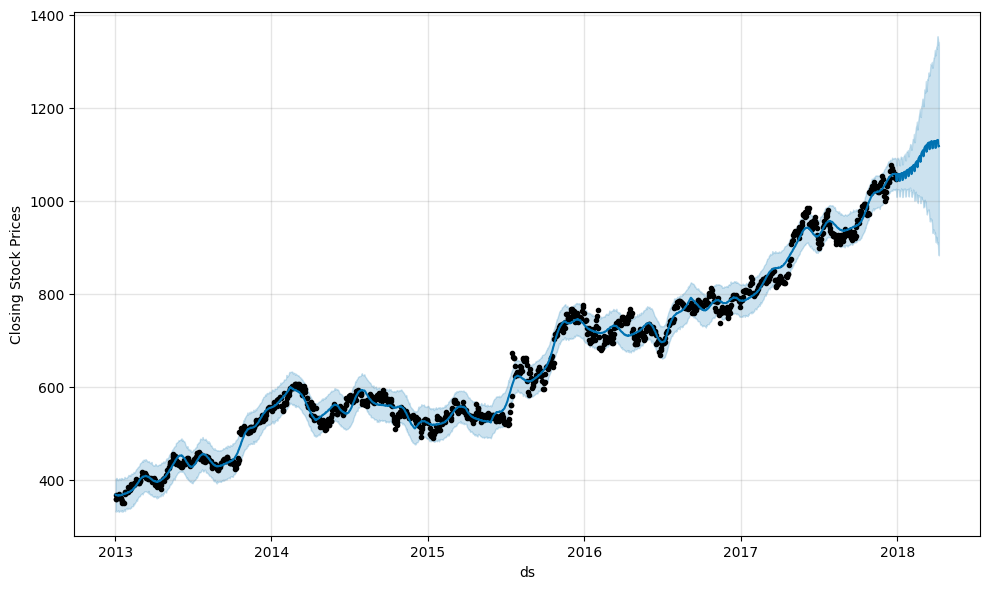

In [38]:
model.plot(forecast,ylabel='Closing Stock Prices');

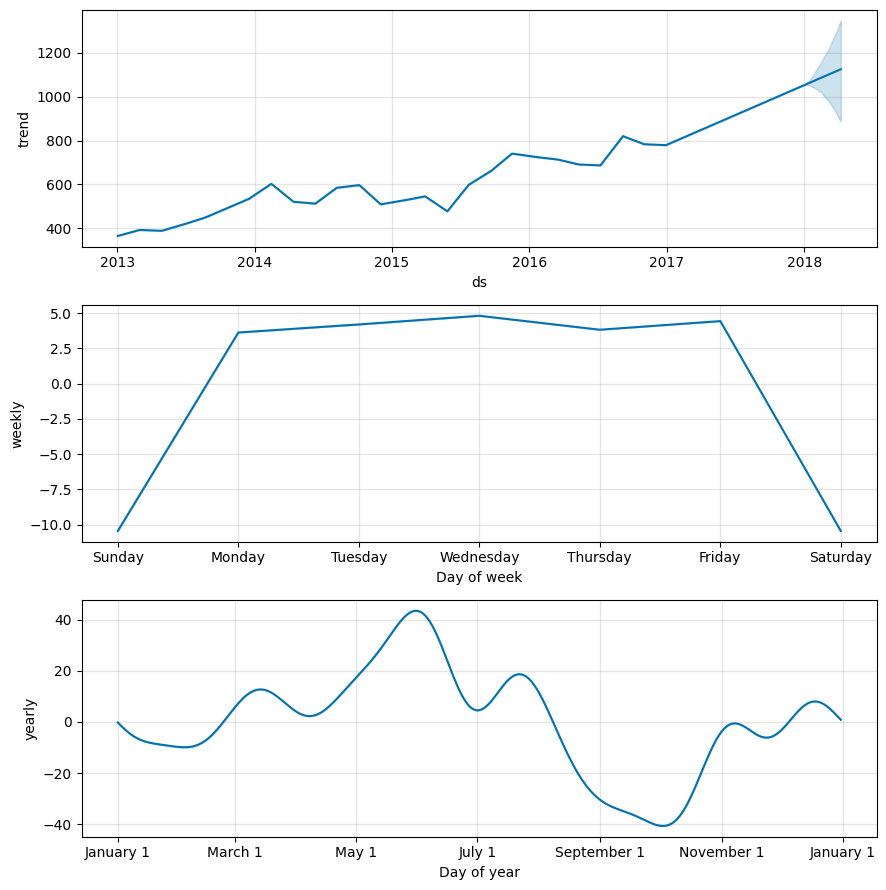

In [39]:
model.plot_components(forecast);

## Bayesian Optimization

In [40]:
def objective(**param_dict):

    param_dict['changepoint_prior_scale'] = np.power(10.,param_dict['changepoint_prior_scale'])
    param_dict['seasonality_prior_scale'] = np.power(10.,param_dict['seasonality_prior_scale'])
    
    model = Prophet(interval_width=0.95,**param_dict)
    model = model.fit(closePrice)

    forecast = model.predict()

    return -np.sqrt(mean_squared_error(closePrice.y.values,forecast.yhat.values))

In [41]:
pbounds = {
    'changepoint_prior_scale': [-3,0],
    'seasonality_prior_scale': [-2,1]
}

In [42]:
optimizer = BayesianOptimization(
    objective,
    pbounds = pbounds,
    verbose = 2,
    random_state = 4)

In [43]:
optimizer.maximize(init_points=10,n_iter=20)

|   iter    |  target   | change... | season... |
-------------------------------------------------


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing


| 1         | -17.43    | -0.09891  | -0.3583   |


21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing


| 2         | -17.41    | -0.08195  | 0.1444    |


21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


| 3         | -18.8     | -0.9068   | -1.352    |


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing


| 4         | -17.44    | -0.07118  | -1.981    |


21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing


| 5         | -34.16    | -2.241    | -0.6956   |


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


| 6         | -18.05    | -0.6619   | -1.407    |


21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing


| 7         | -17.69    | -0.411    | 0.9502    |


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


| 8         | -39.81    | -2.508    | -0.208    |


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


| 9         | -51.79    | -2.973    | -0.8403   |


21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing


| 10        | -45.69    | -2.868    | 0.87      |


21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing


| 11        | -18.85    | -0.9282   | 0.06301   |


21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing


| 12        | -17.35    | 0.0       | 1.0       |


21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


| 13        | -17.4     | 0.0       | -1.29     |


21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing


| 14        | -18.56    | -0.7985   | -2.0      |


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


| 15        | -17.84    | -0.5488   | -0.6547   |


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing


| 16        | -17.39    | 0.0       | 0.6316    |


21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing


| 17        | -17.63    | -0.3782   | 0.3712    |


21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing


| 18        | -17.37    | 0.0       | -0.8231   |


21:46:05 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing


| 19        | -17.49    | -0.2379   | -1.726    |


21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


| 20        | -17.4     | 0.0       | -1.715    |


21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing


| 21        | -17.49    | -0.2107   | -1.056    |


21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] done processing


| 22        | -17.37    | 0.0       | -0.1394   |


21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing


| 23        | -17.42    | -0.1431   | 0.8487    |


21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing


| 24        | -17.39    | -0.002989 | -0.5412   |


21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing


| 25        | -17.39    | 0.0       | 0.326     |


21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing


| 26        | -17.38    | 0.0       | 0.866     |


21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


| 27        | -17.4     | -0.001905 | -1.106    |


21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing


| 28        | -17.44    | -0.1261   | 0.9978    |


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


| 29        | -17.37    | -0.000749 | 0.02704   |


21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


| 30        | -17.38    | 0.0       | -2.0      |


In [44]:
optdict = optimizer.max["params"]

In [45]:
optdict

{'changepoint_prior_scale': 0.0, 'seasonality_prior_scale': 1.0}

In [46]:
optdict['changepoint_prior_scale'] = np.power(10.,optdict['changepoint_prior_scale'])
optdict['seasonality_prior_scale'] = np.power(10.,optdict['seasonality_prior_scale'])

In [47]:
print("Best result: {}; f(x) = {}.".format(optdict,-optimizer.max["target"]))

Best result: {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0}; f(x) = 17.35351291957999.


## Bayesian Optimization Result

In [48]:
model = Prophet(interval_width=0.95,**optdict)

In [49]:
model.fit(closePrice);

21:49:57 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
forecast = model.predict(timeframe)

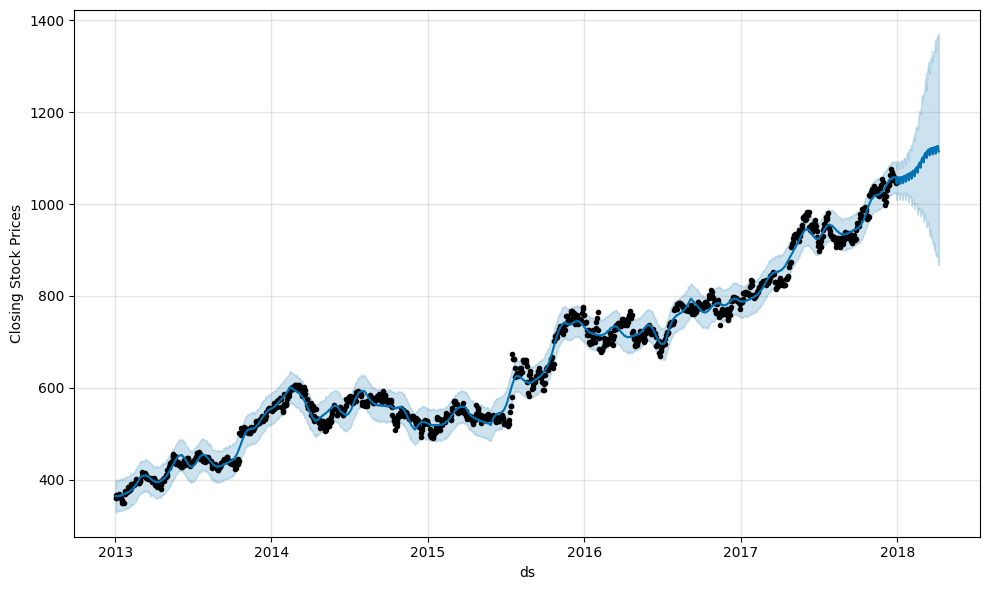

In [51]:
model.plot(forecast,ylabel='Closing Stock Prices');

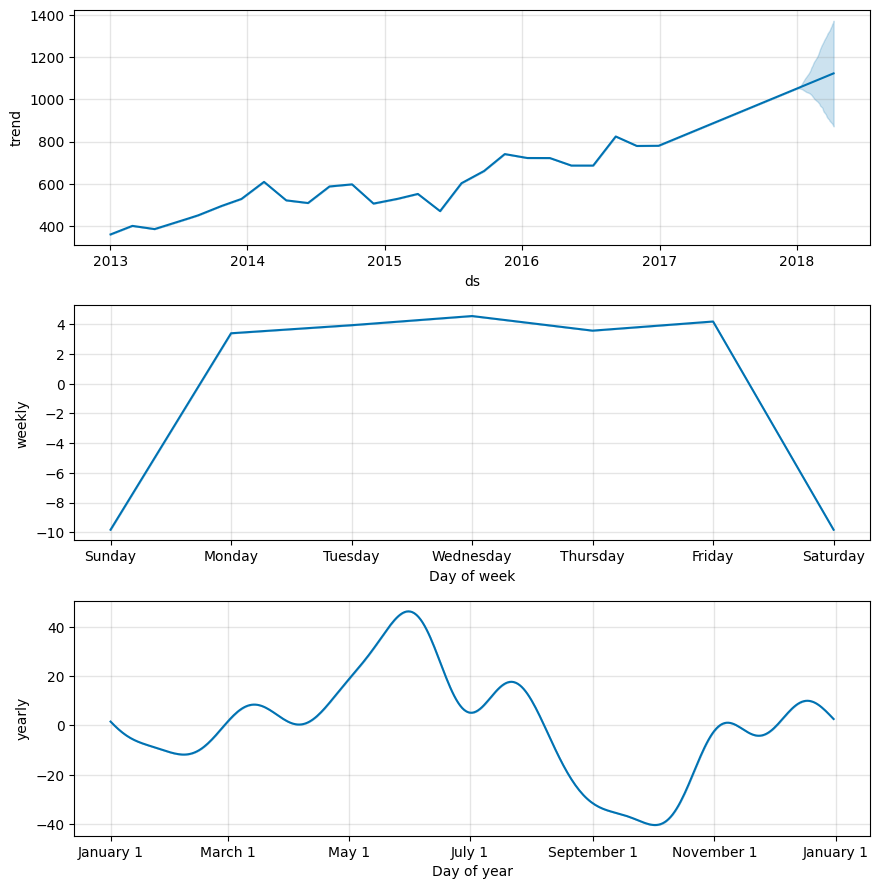

In [52]:
model.plot_components(forecast);